In [1]:
import os
import random
import shutil
from tqdm import tqdm
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Input, Dropout
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import PIL.Image

In [2]:
# Download the dataset
path = kagglehub.dataset_download("hearfool/vggface2")
print("Path to dataset files:", path)

100%|██████████| 2.32G/2.32G [02:04<00:00, 20.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


In [3]:
# Parameters
NUM_CLASSES = 40
IMAGES_PER_CLASS = 200
TRAIN_RATIO = 0.8
IMG_SIZE = (112, 112)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

# Define directories
original_dir = os.path.join(path, "train")
output_dir = "vggface2_split"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [4]:
# Get all class directories
classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

# Select 40 classes randomly
selected_classes = random.sample(classes, NUM_CLASSES)

for cls in tqdm(selected_classes, desc="Processing classes"):
    cls_path = os.path.join(original_dir, cls)
    images = [img for img in os.listdir(cls_path) if img.endswith(".jpg")]

    # Ensure we have at least 200 images
    if len(images) < IMAGES_PER_CLASS:
        print(f"Skipping class {cls} (not enough images)")
        continue

    # Randomly select 200 images
    selected_images = random.sample(images, IMAGES_PER_CLASS)

    # Split into train and test
    split_index = int(TRAIN_RATIO * IMAGES_PER_CLASS)
    train_images = selected_images[:split_index]
    test_images = selected_images[split_index:]

    # Copy to train directory
    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    for img in train_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))

    # Copy to test directory
    test_cls_dir = os.path.join(test_dir, cls)
    os.makedirs(test_cls_dir, exist_ok=True)
    for img in test_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_cls_dir, img))

print("Dataset split completed.")

Processing classes:  57%|█████▊    | 23/40 [00:00<00:00, 36.61it/s]

Skipping class n000360 (not enough images)


Processing classes: 100%|██████████| 40/40 [00:01<00:00, 36.95it/s]

Dataset split completed.


In [5]:
# Preprocessing function with Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

def preprocess_with_augmentation(features, labels):
    features = tf.cast(features, tf.float32) / 255.0  # Normalize
    features = data_augmentation(features)
    return features, labels

def load_images_from_directory(folder_path, img_size=(112, 112)):
    labels = []
    images = []
    class_names = sorted(os.listdir(folder_path))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            if filename.endswith(('.tif', '.jpg', '.png')):
                img_path = os.path.join(class_folder, filename)
                try:
                    img = PIL.Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)  # Resize image
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image: {img_path}")
                    continue
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

def create_tf_datasets():
    train_ds, train_labels, train_classes = load_images_from_directory(train_dir, IMG_SIZE)
    test_ds, test_labels, _ = load_images_from_directory(test_dir, IMG_SIZE)

    train_tensor_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels))
    train_tensor_ds = train_tensor_ds.map(preprocess_with_augmentation).shuffle(5000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    test_tensor_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels))
    test_tensor_ds = test_tensor_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return train_tensor_ds, test_tensor_ds, train_classes

In [6]:
# Define ResNet-18 Architecture with Dropout
def residual_block(inputs, filters, stride=1):
    shortcut = inputs

    # First convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=stride, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if necessary
    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding="same", use_bias=False)(inputs)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [7]:
def build_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolution and max-pooling
    x = Conv2D(64, kernel_size=7, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # Global average pooling, dropout, and dense layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

In [8]:
# Generate TensorFlow datasets
train_ds, test_ds, class_names = create_tf_datasets()
num_classes = len(class_names)

# Build and compile the model
input_shape = IMG_SIZE + (3,)
resnet18 = build_resnet18(input_shape, num_classes)
resnet18.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks for Early Stopping and Model Checkpoint
checkpoint_path = "resnet18_best.keras"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


In [9]:
# Train the model
history = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Save the final model
resnet18.save("resnet18_final_with_dropout.h5")
print("Model training completed and saved.")

Epoch 1/3
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0470 - loss: 4.2024
Epoch 1: val_loss improved from inf to 3.41600, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 96s 30ms/step - accuracy: 0.0470 - loss: 4.2018 - val_accuracy: 0.1058 - val_loss: 3.4160
Epoch 2/3
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0969 - loss: 3.4123
Epoch 2: val_loss improved from 3.41600 to 2.96614, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 137s 30ms/step - accuracy: 0.0969 - loss: 3.4123 - val_accuracy: 0.1635 - val_loss: 2.9661
Epoch 3/3
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1170 - loss: 3.2259
Epoch 3: val_loss did not improve from 2.96614
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.1171 - loss: 3.2259 - val_accuracy: 0.0994 - val_loss: 3.6790


Model training completed and saved.


In [11]:
# Additional training
history1 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    initial_epoch=3,
    callbacks=[checkpoint_cb,early_stopping_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 4/6
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1142 - loss: 3.2862
Epoch 4: val_loss improved from 2.96614 to 2.93791, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - accuracy: 0.1142 - loss: 3.2862 - val_accuracy: 0.2006 - val_loss: 2.9379
Epoch 5/6
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1538 - loss: 3.0704
Epoch 5: val_loss improved from 2.93791 to 2.79623, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 78s 28ms/step - accuracy: 0.1538 - loss: 3.0704 - val_accuracy: 0.2250 - val_loss: 2.7962
Epoch 6/6
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1915 - loss: 2.8708
Epoch 6: val_loss improved from 2.79623 to 2.77056, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.1915 - loss: 2.8708 - val_accuracy: 0.2218 - val_loss: 2.7706


Model training completed and saved.


In [14]:
# Additional training
history2 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=9,
    initial_epoch=6,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated3.h5")
print("Model training completed and saved.")

Epoch 7/9
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2054 - loss: 2.7587
Epoch 7: val_loss improved from 2.77056 to 2.60827, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.2054 - loss: 2.7587 - val_accuracy: 0.2564 - val_loss: 2.6083
Epoch 8/9
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2351 - loss: 2.6439
Epoch 8: val_loss did not improve from 2.60827
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 70s 26ms/step - accuracy: 0.2352 - loss: 2.6439 - val_accuracy: 0.1692 - val_loss: 3.2691
Epoch 9/9
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2811 - loss: 2.4765
Epoch 9: val_loss did not improve from 2.60827
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 77s 26ms/step - accuracy: 0.2811 - loss: 2.4766 - val_accuracy: 0.2494 - val_loss: 2.7720


Model training completed and saved.


In [16]:
# Additional training
history3 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=12,
    initial_epoch=9,
    callbacks=[checkpoint_cb,]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 10/12
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2942 - loss: 2.4129
Epoch 10: val_loss improved from 2.60827 to 2.20006, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.2942 - loss: 2.4129 - val_accuracy: 0.3635 - val_loss: 2.2001
Epoch 11/12
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3209 - loss: 2.2702
Epoch 11: val_loss did not improve from 2.20006
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.3209 - loss: 2.2703 - val_accuracy: 0.2609 - val_loss: 2.7302
Epoch 12/12
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3529 - loss: 2.1501
Epoch 12: val_loss did not improve from 2.20006
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - accuracy: 0.3529 - loss: 2.1501 - val_accuracy: 0.2987 - val_loss: 2.6113


Model training completed and saved.


In [17]:
# Additional training
history4 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    initial_epoch=12,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 13/15
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3953 - loss: 2.0458
Epoch 13: val_loss improved from 2.20006 to 1.82260, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.3953 - loss: 2.0458 - val_accuracy: 0.4628 - val_loss: 1.8226
Epoch 14/15
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4208 - loss: 1.9508
Epoch 14: val_loss improved from 1.82260 to 1.82225, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.4208 - loss: 1.9508 - val_accuracy: 0.4667 - val_loss: 1.8222
Epoch 15/15
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4313 - loss: 1.8944
Epoch 15: val_loss did not improve from 1.82225
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 65s 25ms/step - accuracy: 0.4313 - loss: 1.8944 - val_accuracy: 0.4750 - val_loss: 1.8487


Model training completed and saved.


In [19]:
# Additional training
history5 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=18,
    initial_epoch=15,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 16/18
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4609 - loss: 1.7746
Epoch 16: val_loss did not improve from 1.82225
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.4609 - loss: 1.7746 - val_accuracy: 0.4263 - val_loss: 1.9509
Epoch 17/18
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4859 - loss: 1.6855
Epoch 17: val_loss improved from 1.82225 to 1.57788, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 84s 26ms/step - accuracy: 0.4859 - loss: 1.6855 - val_accuracy: 0.5564 - val_loss: 1.5779
Epoch 18/18
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4923 - loss: 1.6725
Epoch 18: val_loss improved from 1.57788 to 1.44920, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.4923 - loss: 1.6725 - val_accuracy: 0.5763 - val_loss: 1.4492


Model training completed and saved.


In [20]:
# Additional training
history6= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=21,
    initial_epoch=18,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 19/21
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5257 - loss: 1.5609
Epoch 19: val_loss did not improve from 1.44920
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.5257 - loss: 1.5609 - val_accuracy: 0.5846 - val_loss: 1.4549
Epoch 20/21
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5353 - loss: 1.5382
Epoch 20: val_loss did not improve from 1.44920
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.5353 - loss: 1.5382 - val_accuracy: 0.4679 - val_loss: 2.1147
Epoch 21/21
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5744 - loss: 1.4346
Epoch 21: val_loss improved from 1.44920 to 1.43123, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.5744 - loss: 1.4346 - val_accuracy: 0.5891 - val_loss: 1.4312


Model training completed and saved.


In [22]:
# Additional training
history7= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=24,
    initial_epoch=21,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 22/24
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5785 - loss: 1.3874
Epoch 22: val_loss did not improve from 1.43123
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 69s 28ms/step - accuracy: 0.5785 - loss: 1.3875 - val_accuracy: 0.5551 - val_loss: 1.5441
Epoch 23/24
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5879 - loss: 1.3681
Epoch 23: val_loss did not improve from 1.43123
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.5879 - loss: 1.3682 - val_accuracy: 0.4481 - val_loss: 2.2265
Epoch 24/24
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6055 - loss: 1.3069
Epoch 24: val_loss did not improve from 1.43123
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 64s 26ms/step - accuracy: 0.6055 - loss: 1.3069 - val_accuracy: 0.5538 - val_loss: 1.7449


Model training completed and saved.


In [23]:
# Additional training
history8= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=27,
    initial_epoch=24,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 25/27
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6081 - loss: 1.2575
Epoch 25: val_loss did not improve from 1.43123
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step - accuracy: 0.6081 - loss: 1.2576 - val_accuracy: 0.4885 - val_loss: 1.8409
Epoch 26/27
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6331 - loss: 1.2298
Epoch 26: val_loss improved from 1.43123 to 1.32031, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.6331 - loss: 1.2298 - val_accuracy: 0.6199 - val_loss: 1.3203
Epoch 27/27
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6332 - loss: 1.1627
Epoch 27: val_loss improved from 1.32031 to 1.22227, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - accuracy: 0.6332 - loss: 1.1627 - val_accuracy: 0.6397 - val_loss: 1.2223


Model training completed and saved.


In [24]:
from google.colab import drive
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/models/final/resnet18_updated2.h5"
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)


Mounted at /content/drive
Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [26]:
# Additional training
history9= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    initial_epoch=27,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 28/30
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6460 - loss: 1.1519
Epoch 28: val_loss improved from 1.22227 to 1.21032, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.6460 - loss: 1.1519 - val_accuracy: 0.6564 - val_loss: 1.2103
Epoch 29/30
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6733 - loss: 1.0803
Epoch 29: val_loss did not improve from 1.21032
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 84s 25ms/step - accuracy: 0.6733 - loss: 1.0804 - val_accuracy: 0.6577 - val_loss: 1.2451
Epoch 30/30
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6727 - loss: 1.0502
Epoch 30: val_loss did not improve from 1.21032
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 70s 28ms/step - accuracy: 0.6727 - loss: 1.0502 - val_accuracy: 0.5615 - val_loss: 1.8116


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [28]:
# Additional training
history10= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=33,
    initial_epoch=30,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 31/33
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6754 - loss: 1.0397
Epoch 31: val_loss did not improve from 1.21032
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.6754 - loss: 1.0397 - val_accuracy: 0.6179 - val_loss: 1.3624
Epoch 32/33
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6924 - loss: 1.0005
Epoch 32: val_loss did not improve from 1.21032
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 68s 25ms/step - accuracy: 0.6924 - loss: 1.0005 - val_accuracy: 0.6635 - val_loss: 1.2109
Epoch 33/33
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7036 - loss: 0.9515
Epoch 33: val_loss improved from 1.21032 to 1.20913, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 70s 26ms/step - accuracy: 0.7036 - loss: 0.9515 - val_accuracy: 0.6801 - val_loss: 1.2091


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [30]:
# Additional training
history11 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=36,
    initial_epoch=33,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)


Epoch 34/36
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7165 - loss: 0.9298
Epoch 34: val_loss did not improve from 1.20913
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 67s 25ms/step - accuracy: 0.7165 - loss: 0.9299 - val_accuracy: 0.6635 - val_loss: 1.2580
Epoch 35/36
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7172 - loss: 0.8978
Epoch 35: val_loss did not improve from 1.20913
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step - accuracy: 0.7172 - loss: 0.8978 - val_accuracy: 0.6154 - val_loss: 1.4449
Epoch 36/36
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7149 - loss: 0.9057
Epoch 36: val_loss did not improve from 1.20913
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.7149 - loss: 0.9057 - val_accuracy: 0.6058 - val_loss: 1.4380


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [32]:
# Additional training
history12 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=39,
    initial_epoch=36,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 37/39
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7418 - loss: 0.8524
Epoch 37: val_loss improved from 1.20913 to 1.02310, saving model to resnet18_best.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 68s 26ms/step - accuracy: 0.7418 - loss: 0.8524 - val_accuracy: 0.7147 - val_loss: 1.0231
Epoch 38/39
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7348 - loss: 0.8409
Epoch 38: val_loss did not improve from 1.02310
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.7348 - loss: 0.8409 - val_accuracy: 0.6808 - val_loss: 1.2270
Epoch 39/39
1558/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7469 - loss: 0.8246
Epoch 39: val_loss did not improve from 1.02310
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - accuracy: 0.7469 - loss: 0.8246 - val_accuracy: 0.6308 - val_loss: 1.5540


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [33]:
# Additional training
history13 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    initial_epoch=39,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 40/40
1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7504 - loss: 0.8083
Epoch 40: val_loss did not improve from 1.02310
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 68s 26ms/step - accuracy: 0.7504 - loss: 0.8083 - val_accuracy: 0.7083 - val_loss: 1.0922


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [34]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = resnet18.evaluate(test_ds, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7062 - loss: 1.0992
Test Loss: 1.0922
Test Accuracy: 0.7083


In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model predictions on the test dataset
y_true = []
y_pred = []
y_pred_probs = []

# Iterate over the test dataset to collect predictions and true labels
for features, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(resnet18.predict(features))
    y_pred.extend(np.argmax(resnet18.predict(features), axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

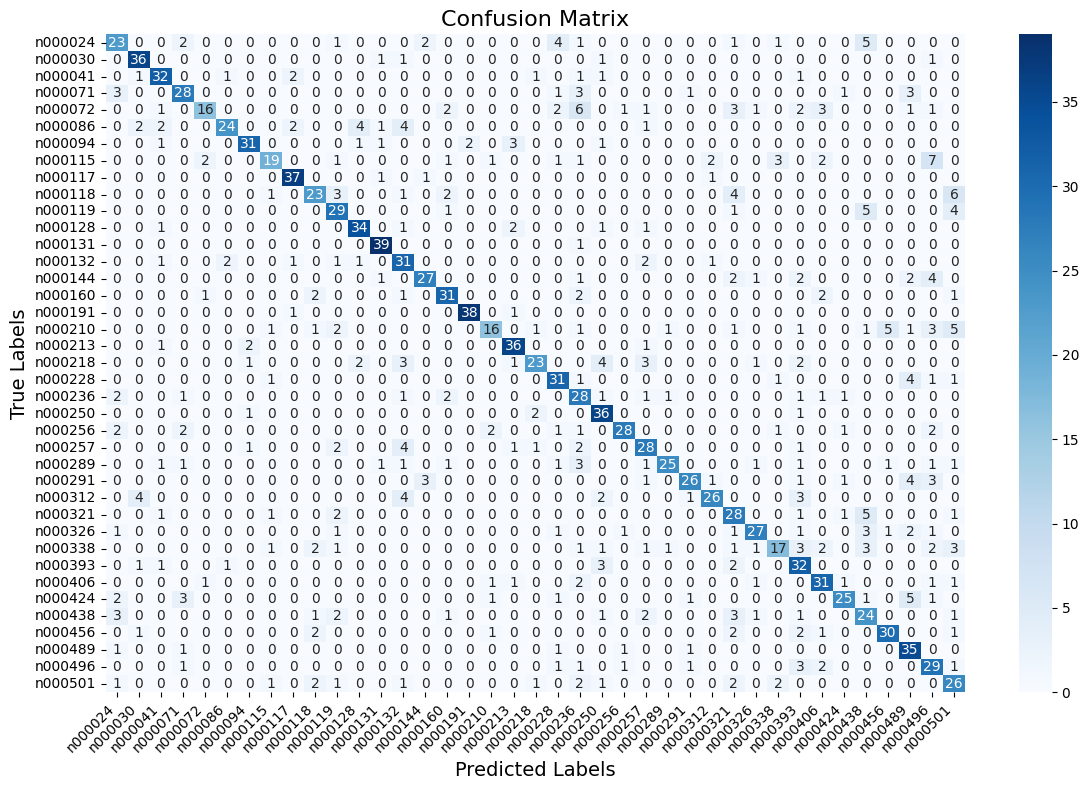

In [36]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


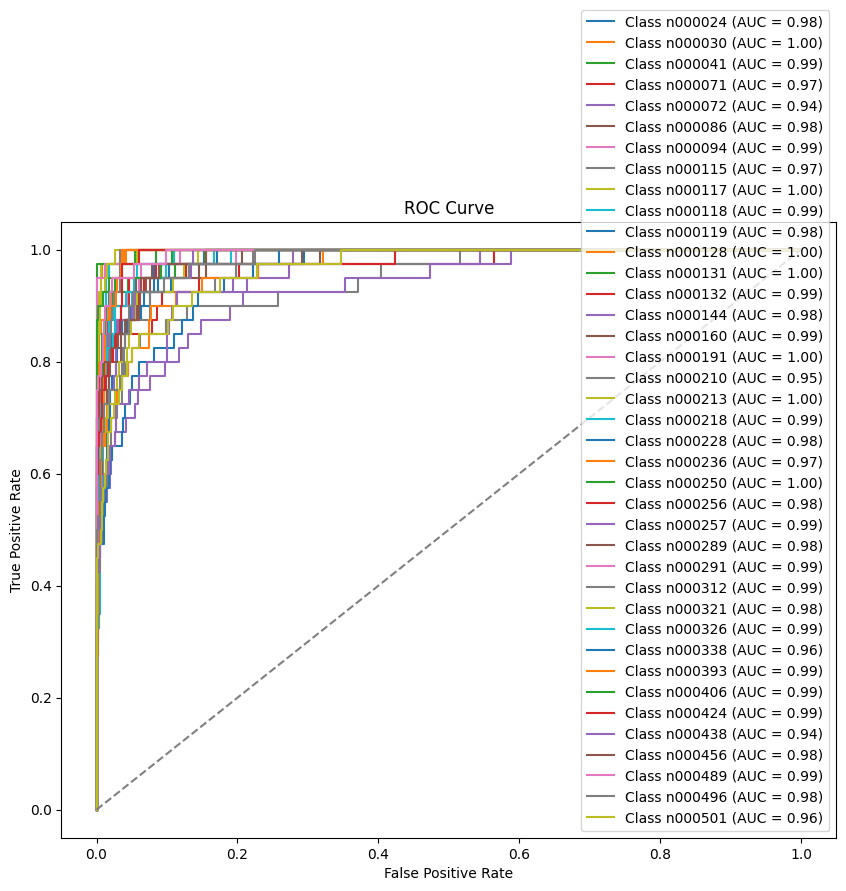

Macro-Average ROC AUC: 0.98


In [37]:
# Compute ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Add random chance line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Compute overall macro-average ROC AUC
macro_roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="macro")
print(f"Macro-Average ROC AUC: {macro_roc_auc:.2f}")

Classification Report:
              precision    recall  f1-score   support

     n000024       0.61      0.57      0.59        40
     n000030       0.80      0.90      0.85        40
     n000041       0.76      0.80      0.78        40
     n000071       0.72      0.70      0.71        40
     n000072       0.80      0.40      0.53        40
     n000086       0.86      0.60      0.71        40
     n000094       0.86      0.78      0.82        40
     n000115       0.76      0.47      0.58        40
     n000117       0.86      0.93      0.89        40
     n000118       0.70      0.57      0.63        40
     n000119       0.63      0.72      0.67        40
     n000128       0.81      0.85      0.83        40
     n000131       0.87      0.97      0.92        40
     n000132       0.58      0.78      0.67        40
     n000144       0.82      0.68      0.74        40
     n000160       0.76      0.78      0.77        40
     n000191       0.95      0.95      0.95        40
    

<Figure size 1000x800 with 0 Axes>

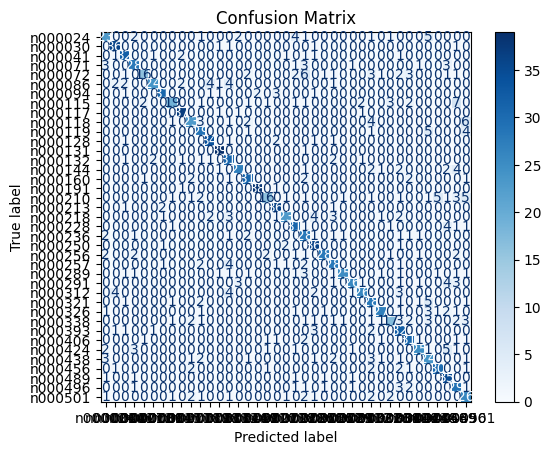

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Optional: Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [39]:
# Merge histories from all training phases
def combine_histories(*histories):
    combined_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for hist in histories:
        for key in combined_history.keys():
            combined_history[key].extend(hist.history[key])
    return combined_history

# Combine histories
full_history = combine_histories(history, history1, history2, history3, history4, history5, history6, history7, history8, history9, history10, history11, history12, history13)

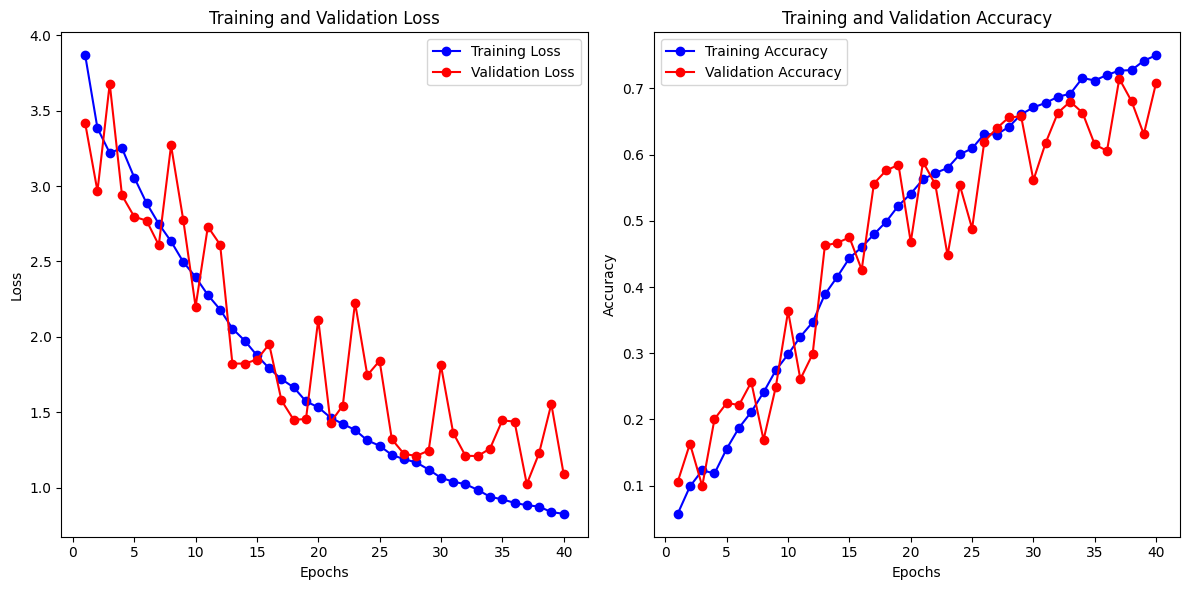

In [40]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_full_training_history(full_history):
    epochs = range(1, len(full_history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, full_history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, full_history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, full_history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, full_history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the combined training history
plot_full_training_history(full_history)
